In [1]:
%vertica SELECT 'Connected to Vertica!'

,?column?
0,Connected to Vertica!


In [2]:
import datetime
from dateutil.tz import gettz, tzutc

experiment_start = datetime.datetime(2017, 7, 19, 14, 40, tzinfo=gettz('America/New_York'))
experiment_id = 4

In [3]:
%%vertica
SET TIME ZONE TO UTC

# Look at email interactions (open rates, CTR etc)

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


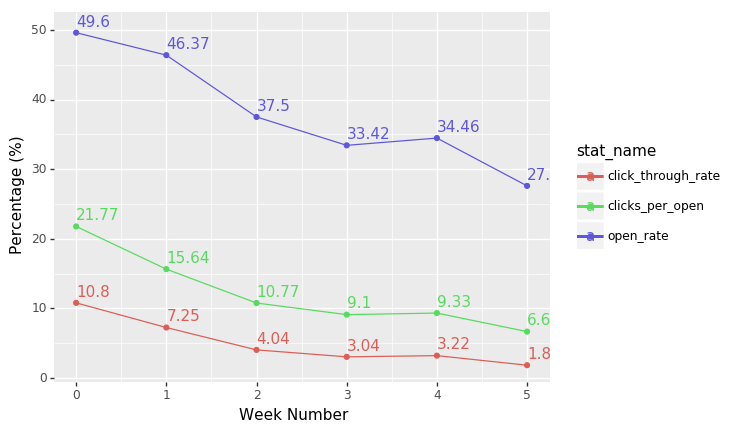

<ggplot: (8726376858979)>

,stat_name,value,week_num
0,open_rate,0.495992,0
1,click_through_rate,0.107968,0
2,opt_out_rate,0.000943,0
3,clicks_per_open,0.217681,0
4,sent,2121.000000,0
5,open_rate,0.463740,1
6,click_through_rate,0.072521,1
7,opt_out_rate,0.000392,1
8,clicks_per_open,0.156382,1
9,sent,5102.000000,1


In [4]:
import edx_sailthru

edx_sailthru.get_weekly_stats(
    template='RET Pacing',
    # Note that we didn't send an email the first week...
    start_date=experiment_start.date() + datetime.timedelta(days=7),
    num_weeks=6
)

We have to extract the course ID from the keys in the key-value store experiment data table. Note we can't split on the "." symbol since it appears in some course IDs.

In [5]:
%%vertica (experiment_id) -> experiment_users
SELECT
    user_id,
    SUBSTRING(key FROM 26) AS course_id,
    CASE MAPLOOKUP(MAPJSONEXTRACTOR(value), 'segment')
        WHEN 0 THEN 'Control'
        WHEN 1 THEN 'Treatment'
    END AS group_name,
    MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date
FROM
    lms_read_replica.experiments_experimentdata
WHERE
    experiment_id = :experiment_id

In [6]:
experiment_users.groupby(['group_name']).user_id.count()

group_name
Control      5385
Treatment    5439
Name: user_id, dtype: int64

In [7]:
%%vertica -> max_act
SELECT
    MAX(date) AS max_activity_date
FROM
    production.f_user_activity

In [8]:
max_activity_date = max_act.loc[0].max_activity_date

In [9]:
experiment_users.groupby(['cohort_availability_date']).user_id.count()

cohort_availability_date
2017-07-19    5299
2017-07-26    5525
Name: user_id, dtype: int64

In [10]:
%%vertica (experiment_start, experiment_id, max_activity_date) -> engagement

-- This should return one record per enrollment per week
SELECT
    ee.user_id,
    ee.course_id,
    ee.group_name,
    ee.cohort_availability_date,
    weeks.week_since_cohort_availability,
    MAX(COALESCE(act.is_engaged, 0)) AS is_engaged,
    SUM(COALESCE(act.cnt_engaged_activity, 0)) AS cnt_engaged_activity
FROM
(
    SELECT
        user_id,
        SUBSTRING(key FROM 26) AS course_id,
        CASE MAPLOOKUP(MAPJSONEXTRACTOR(value), 'segment')
            WHEN 0 THEN 'Control'
            WHEN 1 THEN 'Treatment'
        END AS group_name,
        MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date
    FROM
        lms_read_replica.experiments_experimentdata
    WHERE
        experiment_id = :experiment_id
    ORDER BY 1, 2
) ee

JOIN
(
    SELECT
        eei.cohort_availability_date,
        FLOOR(DATEDIFF('day', eei.cohort_availability_date, cal.date) / 7) AS week_since_cohort_availability
    FROM
    (
        SELECT DISTINCT
            MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date
        FROM
            lms_read_replica.experiments_experimentdata
        WHERE
            experiment_id = :experiment_id
        ORDER BY 1
    ) eei

    JOIN
        business_intelligence.calendar cal
    ON
        cal.date BETWEEN eei.cohort_availability_date AND :max_activity_date
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT cal.date) = 7
) weeks ON ee.cohort_availability_date = weeks.cohort_availability_date

LEFT JOIN
(
    SELECT
        user_id,
        course_id,
        date,
        CASE WHEN SUM(number_of_activities) > 0 THEN 1 ELSE 0 END AS is_engaged,
        SUM(number_of_activities) AS cnt_engaged_activity
    FROM
        production.f_user_activity
    WHERE
        date >= CAST(:experiment_start AS DATE)
        AND activity_type IN ('PLAYED_VIDEO', 'POSTED_FORUM', 'ATTEMPTED_PROBLEM')
    GROUP BY 1, 2, 3
    ORDER BY 1, 2
) act
ON
    act.user_id = ee.user_id
    AND act.course_id = ee.course_id
    AND FLOOR(DATEDIFF('day', ee.cohort_availability_date, act.date) / 7) = weeks.week_since_cohort_availability
GROUP BY 1, 2, 3, 4, 5

In [11]:
engagement.groupby(['cohort_availability_date', 'week_since_cohort_availability']).user_id.count()

cohort_availability_date  week_since_cohort_availability
2017-07-19                0                                 5299
                          1                                 5299
                          2                                 5299
                          3                                 5299
                          4                                 5299
                          5                                 5299
2017-07-26                0                                 5525
                          1                                 5525
                          2                                 5525
                          3                                 5525
                          4                                 5525
Name: user_id, dtype: int64

In [12]:
engagement.groupby(['week_since_cohort_availability', 'group_name']).user_id.count()

week_since_cohort_availability  group_name
0                               Control       5385
                                Treatment     5439
1                               Control       5385
                                Treatment     5439
2                               Control       5385
                                Treatment     5439
3                               Control       5385
                                Treatment     5439
4                               Control       5385
                                Treatment     5439
5                               Control       2626
                                Treatment     2673
Name: user_id, dtype: int64

In [13]:
engagement.groupby(['week_since_cohort_availability', 'group_name']).is_engaged.value_counts()

week_since_cohort_availability  group_name  is_engaged
0                               Control     0             3487
                                            1             1898
                                Treatment   0             3378
                                            1             2061
1                               Control     0             4697
                                            1              688
                                Treatment   0             4512
                                            1              927
2                               Control     0             4977
                                            1              408
                                Treatment   0             4880
                                            1              559
3                               Control     0             5092
                                            1              293
                                Treatment   0             5037


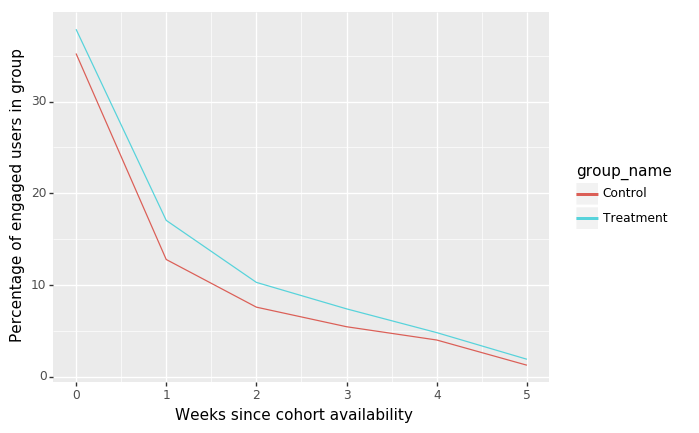

<ggplot: (8736250658701)>

In [14]:
import pandas as pd
from plotnine import *
from IPython.display import display

users_per_group = engagement[engagement.week_since_cohort_availability == 0].groupby(['group_name']).user_id.count()

data = []
for key, group in engagement.groupby(['week_since_cohort_availability', 'group_name', 'is_engaged']):
    week_since_cohort_availability, group_name, is_engaged = key
    cnt_users_in_group = int(users_per_group[group_name])
    cnt_users = len(group)
    data.append(
        {
            'week_since_cohort_availability': int(week_since_cohort_availability),
            'group_name': group_name,
            'is_engaged': bool(is_engaged),
            'cnt_users': cnt_users,
            'cnt_users_in_group': cnt_users_in_group,
            'ratio': float(cnt_users) / cnt_users_in_group,
        }
    )

engaged_over_time = pd.DataFrame(data)

display(
    ggplot(
        engaged_over_time[engaged_over_time.is_engaged],
        aes(
            x='week_since_cohort_availability',
            y='ratio * 100',
            color='group_name'
        )
    )
    + geom_line()
    + xlab('Weeks since cohort availability')
    + ylab('Percentage of engaged users in group')
)

In [15]:
import edx_stats
import edx_plot
from plotnine import *
from IPython.display import display

def compute_confidence_interval(df, variant_col, value_col, title, group_by=None):
    conf_intervals = edx_stats.grouped_confidence_intervals(
        df.reset_index(),
        variant_col=variant_col,
        value_col=value_col,
        ctrl_name='Control',
        group_cols=[group_by] if group_by else []
    )
    plot = (
        ggplot(conf_intervals.reset_index(), aes(
            x=group_by or variant_col,
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5,
        ))
        + edx_plot.geom_confidence()
        + edx_plot.theme_confidence()
        + ggtitle(title)
    )
    if group_by:
        plot += facet_grid(". ~ " + variant_col)
    display(plot)
    return conf_intervals

## Count enrollments that engaged with the course at all during the week

/app/lib/edx_stats.py:124: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


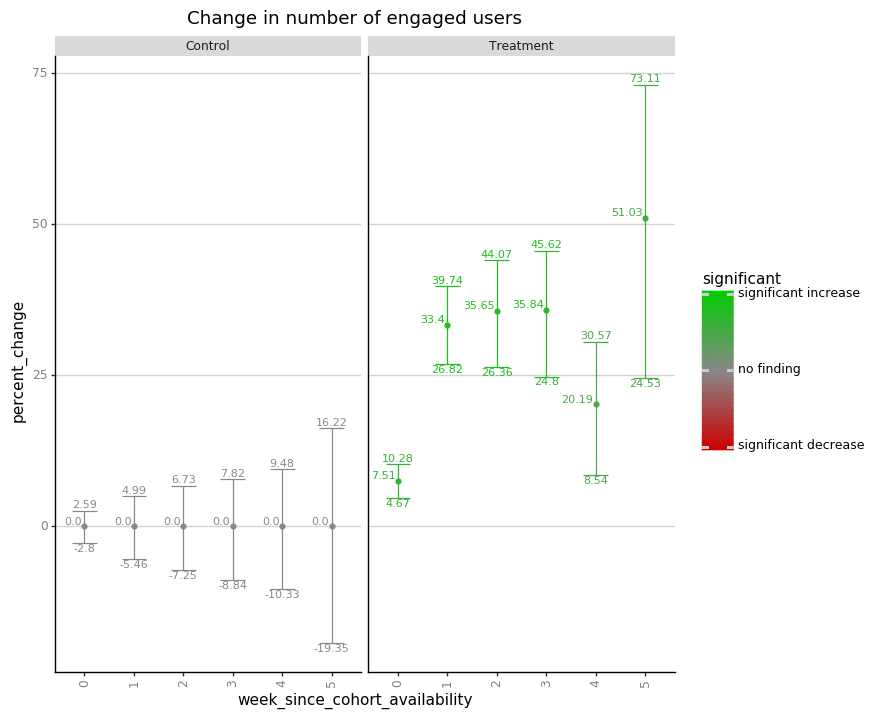

<ggplot: (8736250668969)>

lower_bound  percent_change  \
week_since_cohort_availability group_name                                
0                              Control       -2.797260        0.000000   
                               Treatment      4.668889        7.509894   
1                              Control       -5.463192        0.000000   
                               Treatment     26.824857       33.400650   
2                              Control       -7.250000        0.000000   
                               Treatment     26.359209       35.649530   
3                              Control       -8.843537        0.000000   
                               Treatment     24.799610       35.839189   
4                              Control      -10.328638        0.000000   
                               Treatment      8.536480       20.190100   
5                              Control      -19.354839        0.000000   
                               Treatment     24.532064       51.028248   

                                           upper_bound  significant  
week_since_cohort_availability group_name                            
0                              Control        2.587531     0.000000  
                               Treatment     10.283767     0.621698  
1                              Control        4.985814     0.000000  
                               Treatment     39.740168     0.803124  
2                              Control        6.728538     0.000000  
                               Treatment     44.070220     0.739398  
3                              Control        7.818421     0.000000  
                               Treatment     45.618863     0.691969  
4                              Control        9.482759     0.000000  
                               Treatment     30.572247     0.422805  
5                              Control       16.216216     0.000000  
                               Treatment     73.114297     0.480755

In [16]:
compute_confidence_interval(
    engagement,
    variant_col='group_name',
    value_col='is_engaged',
    title='Change in number of engaged users',
    group_by='week_since_cohort_availability'
)

# Change in engagement over the course of the entire experiment

In [17]:
%%vertica (experiment_start, experiment_id, max_activity_date) -> engagement_all

-- This should return one record per enrollment per week
SELECT
    ee.user_id,
    ee.course_id,
    ee.group_name,
    MAX(COALESCE(act.is_engaged, 0)) AS is_engaged,
    SUM(COALESCE(act.cnt_engaged_activity, 0)) AS cnt_engaged_activity
FROM
(
    SELECT
        user_id,
        SUBSTRING(key FROM 26) AS course_id,
        CASE MAPLOOKUP(MAPJSONEXTRACTOR(value), 'segment')
            WHEN 0 THEN 'Control'
            WHEN 1 THEN 'Treatment'
        END AS group_name,
        MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date
    FROM
        lms_read_replica.experiments_experimentdata
    WHERE
        experiment_id = :experiment_id
    ORDER BY 1, 2
) ee

JOIN
(
    SELECT
        eei.cohort_availability_date,
        FLOOR(DATEDIFF('day', eei.cohort_availability_date, cal.date) / 7) AS week_since_cohort_availability
    FROM
    (
        SELECT DISTINCT
            MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date
        FROM
            lms_read_replica.experiments_experimentdata
        WHERE
            experiment_id = :experiment_id
        ORDER BY 1
    ) eei

    JOIN
        business_intelligence.calendar cal
    ON
        cal.date BETWEEN eei.cohort_availability_date AND :max_activity_date
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT cal.date) = 7
) weeks ON ee.cohort_availability_date = weeks.cohort_availability_date

LEFT JOIN
(
    SELECT
        user_id,
        course_id,
        date,
        CASE WHEN SUM(number_of_activities) > 0 THEN 1 ELSE 0 END AS is_engaged,
        SUM(number_of_activities) AS cnt_engaged_activity
    FROM
        production.f_user_activity
    WHERE
        date >= CAST(:experiment_start AS DATE)
        AND activity_type IN ('PLAYED_VIDEO', 'POSTED_FORUM', 'ATTEMPTED_PROBLEM')
    GROUP BY 1, 2, 3
    ORDER BY 1, 2
) act
ON
    act.user_id = ee.user_id
    AND act.course_id = ee.course_id
    AND FLOOR(DATEDIFF('day', ee.cohort_availability_date, act.date) / 7) = weeks.week_since_cohort_availability
GROUP BY 1, 2, 3

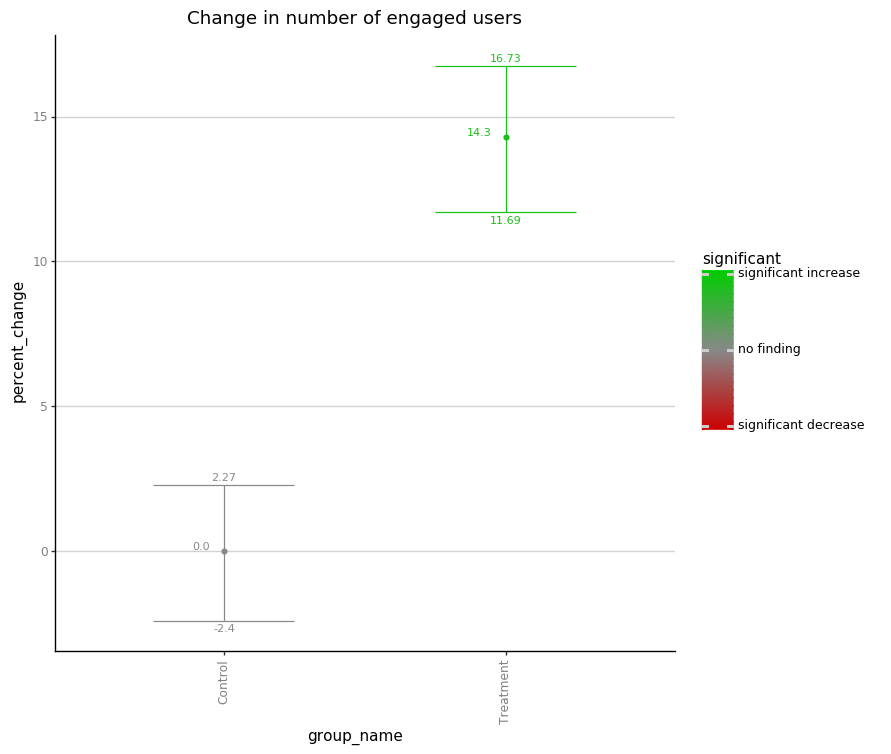

<ggplot: (8736250633792)>

,lower_bound,percent_change,upper_bound,significant
group_name,,,,
Control,-2.397765,0.000000,2.273849,0.000000
Treatment,11.692006,14.298854,16.733646,0.817688


In [18]:
compute_confidence_interval(
    engagement_all,
    variant_col='group_name',
    value_col='is_engaged',
    title='Change in number of engaged users'
)

# Bookings and VTR in the course we emailed them about

In [19]:
%%vertica (experiment_start, experiment_id) -> conversions

-- This query should return one record per enrollment.
SELECT
    ee.user_id,
    ee.course_id,
    ee.group_name,
    ee.cohort_availability_date,
    COALESCE(duc.first_verified_enrollment_time >= ee.exposure_time, false) AS verified_after_exposure,
    COALESCE(duc.first_verified_enrollment_time >= ee.cohort_availability_date, false) AS verified_after_cohort_availability,
    duc.verified,
    duc.gross_bookings
FROM
(
    SELECT
        user_id,
        SUBSTRING(key FROM 26) AS course_id,
        CASE MAPLOOKUP(MAPJSONEXTRACTOR(value), 'segment')
            WHEN 0 THEN 'Control'
            WHEN 1 THEN 'Treatment'
        END AS group_name,
        MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date,
        created AS exposure_time
    FROM
        lms_read_replica.experiments_experimentdata
    WHERE
        experiment_id = :experiment_id
    ORDER BY 1, 2
) ee

JOIN
(
    SELECT
        uc.user_id,
        uc.course_id,
        uc.first_verified_enrollment_time,
        CASE WHEN uc.first_verified_enrollment_time IS NOT NULL THEN cm.course_seat_price ELSE 0 END AS gross_bookings,
        uc.first_verified_enrollment_time IS NOT NULL AS verified
    FROM
        production.d_user_course uc
    JOIN
        business_intelligence.course_master cm ON cm.course_id = uc.course_id
    ORDER BY 1, 2
) duc
ON
    duc.user_id = ee.user_id
    AND duc.course_id = ee.course_id

In [20]:
len(conversions)

10824

In [21]:
conversions.groupby(['group_name']).user_id.count()

group_name
Control      5385
Treatment    5439
Name: user_id, dtype: int64

In [22]:
conversions.groupby(['group_name']).verified.value_counts()

group_name  verified
Control     False       5318
            True          67
Treatment   False       5328
            True         111
Name: verified, dtype: int64

In [23]:
conversions.groupby(['group_name']).verified_after_cohort_availability.value_counts()

group_name  verified_after_cohort_availability
Control     False                                 5318
            True                                    67
Treatment   False                                 5328
            True                                   111
Name: verified_after_cohort_availability, dtype: int64

In [24]:
conversions.groupby(['group_name']).verified_after_exposure.value_counts()

group_name  verified_after_exposure
Control     False                      5357
            True                         28
Treatment   False                      5372
            True                         67
Name: verified_after_exposure, dtype: int64

In [25]:
a = conversions.groupby(['user_id', 'course_id']).size()
assert len(a[a > 1]) == 0, 'There should be exactly one record per enrollment'

In [26]:
totals = conversions.groupby('group_name').verified.count()
converted = conversions.groupby('group_name').verified.sum()

print(totals)
print(converted)
converted / totals

group_name
Control      5385
Treatment    5439
Name: verified, dtype: int64
group_name
Control       67.0
Treatment    111.0
Name: verified, dtype: float64


group_name
Control      0.012442
Treatment    0.020408
Name: verified, dtype: float64

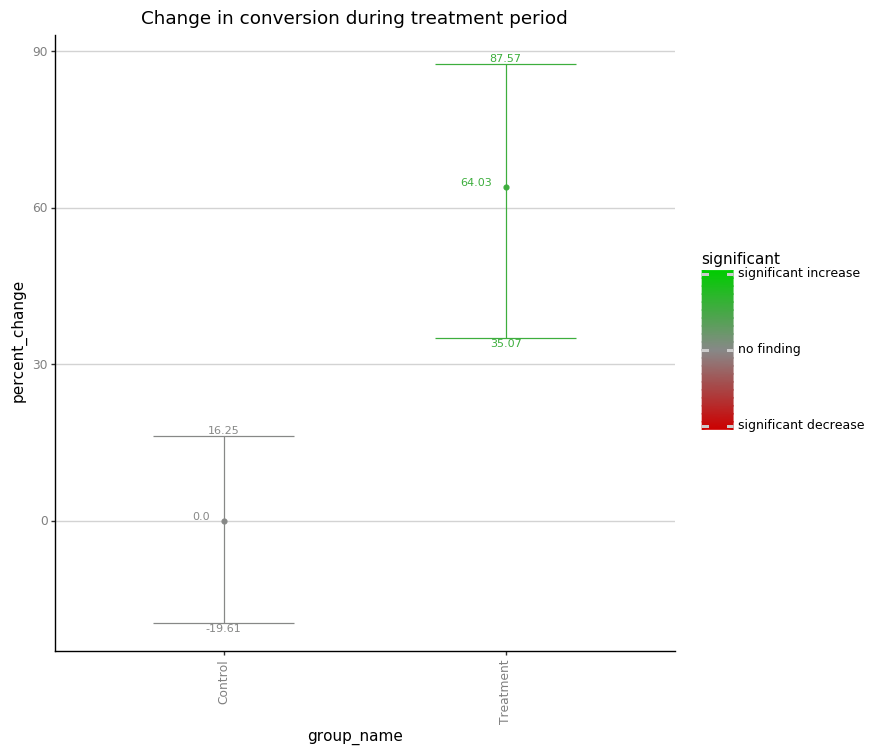

<ggplot: (-9223363300604131724)>

,lower_bound,percent_change,upper_bound,significant
group_name,,,,
Control,-19.607843,0.000000,16.250000,0.000000
Treatment,35.073532,64.026805,87.570462,0.547795


In [27]:
compute_confidence_interval(
    conversions,
    variant_col='group_name',
    value_col='verified',
    title='Change in conversion during treatment period'
)

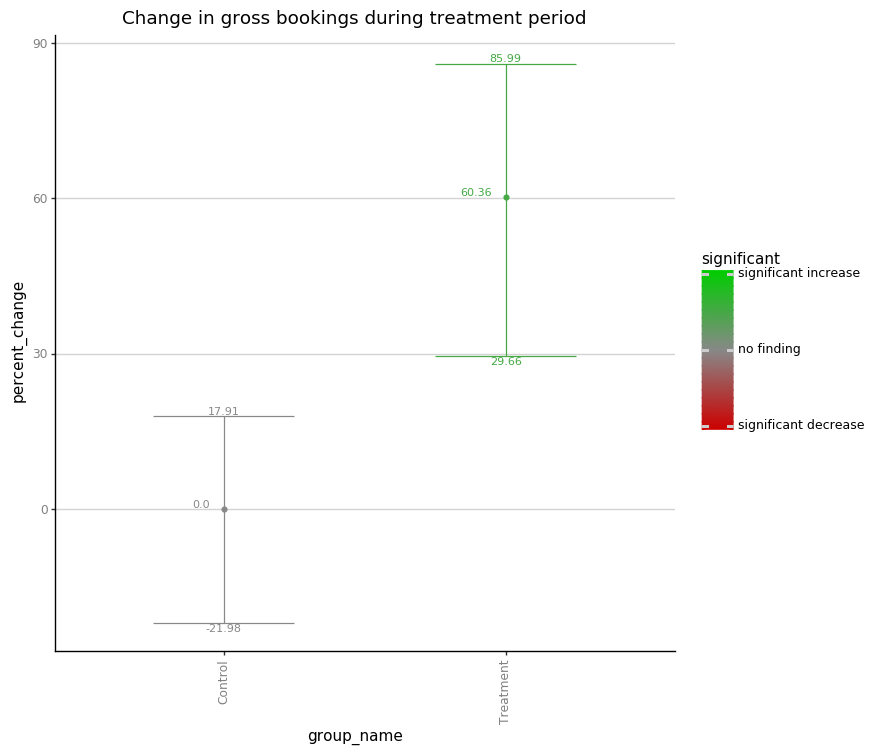

<ggplot: (-9223363300610800412)>

,lower_bound,percent_change,upper_bound,significant
group_name,,,,
Control,-21.981263,0.000000,17.907749,0.000000
Treatment,29.656998,60.355927,85.993400,0.491368


In [28]:
compute_confidence_interval(
    conversions,
    variant_col='group_name',
    value_col='gross_bookings',
    title='Change in gross bookings during treatment period'
)

# Look at the time of verification

TODO: Remove courses that cost more than our MAX(target courses cost) our less than our MIN(target courses cost) -- do this in addition to the below, not instead of.

In [29]:
%%vertica (experiment_start, experiment_id) -> audit_duration_counts

SELECT
    exp.variation_name IS NULL AS is_baseline,
    CASE
        WHEN exp.variation_name IS NOT NULL THEN exp.variation_name || '_' || exp.cohort_availability_date
        ELSE c.pacing_type || '_baseline'
    END AS variation_name,
    CASE
        WHEN duc.first_verified_enrollment_time IS NULL THEN DATEDIFF('day', duc.content_availability_date, NOW())
        ELSE DATEDIFF('day', duc.content_availability_date, duc.first_verified_enrollment_time)
    END AS duration,
    duc.first_verified_enrollment_time IS NOT NULL AS verified,
    COUNT(*) AS cnt_users
FROM
    business_intelligence.user_content_availability_date duc
LEFT JOIN
(
    SELECT
        user_id,
        SUBSTRING(key FROM 26) AS course_id,
        CASE MAPLOOKUP(MAPJSONEXTRACTOR(value), 'segment')
            WHEN 0 THEN 'Control'
            WHEN 1 THEN 'Treatment'
        END AS variation_name,
        MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date
    FROM
        lms_read_replica.experiments_experimentdata
    WHERE
        experiment_id = :experiment_id
) exp ON exp.user_id = duc.user_id AND exp.course_id = duc.course_id
JOIN business_intelligence.course_master AS c ON c.course_id = duc.course_id
JOIN production.d_user AS du ON du.user_id = duc.user_id
WHERE
    -- only include enrollments that occurred after the course started and before the verification deadline
    duc.content_availability_date <= c.course_verification_end_date
    
    AND du.user_email NOT LIKE '%@edx.org'
    
    AND (
        -- segmentation ensures that you only have a row in the experimentdata table iff you are in the
        -- experiment
        exp.course_id IS NOT NULL
        OR
        -- for all others, just use recent enrollments
        duc.content_availability_date > '2017-04-01'
    )
    
    AND (
        c.pacing_type = 'self_paced'
        OR
        duc.first_enrollment_time BETWEEN c.course_start_date AND (c.course_start_date + 6)
    )
    
    AND c.course_partner != 'Microsoft'

GROUP BY 1, 2, 3, 4
ORDER BY 1, 4, 2, 3

In [30]:
audit_duration_counts.groupby(['verified', 'variation_name']).cnt_users.sum()

verified  variation_name           
False     Control_2017-07-19              2585
          Control_2017-07-26              2721
          Treatment_2017-07-19            2615
          Treatment_2017-07-26            2703
          instructor_paced_baseline     151137
          self_paced_baseline          2988087
True      Control_2017-07-19                31
          Control_2017-07-26                36
          Treatment_2017-07-19              50
          Treatment_2017-07-26              61
          instructor_paced_baseline       4839
          self_paced_baseline            35658
Name: cnt_users, dtype: int64

In [31]:
import pandas as pd
import itertools
def explode_dataframe(df, count_col='cnt_users'):
    """
    Convert a dataframe with counts in ``count_col``
    into a dataframe with ``count_col`` copies of each row.
    """
    
    non_counted_columns = df.columns[df.columns != count_col]
    
    def duplicate_row(row):
        row_tuple = tuple(row[non_counted_columns])
        for _ in range(row[count_col]):
            yield row_tuple
                          
    return pd.DataFrame(
        list(itertools.chain.from_iterable(
            duplicate_row(row) for
            _, row in df.iterrows()
        )),
        columns=non_counted_columns
    )

In [32]:
import pandas as pd
from lifelines import KaplanMeierFitter

plot_num = 0
all_enrollees = pd.DataFrame(columns=['ts', 'ps', 'ps_hi', 'ps_lo', 'is_baseline', 'variation_name'])
        
kmf = KaplanMeierFitter()

for key, group in audit_duration_counts.groupby(
    ['is_baseline', 'variation_name']
):
    is_baseline, variation_name = key

    exploded_group = explode_dataframe(group)
    kmf.fit(exploded_group.duration, event_observed=exploded_group.verified)
    del exploded_group

    ts = kmf.survival_function_.index.values
    ps = 1.0 - kmf.survival_function_['KM_estimate'].values
    ps_hi = 1.0 - kmf.confidence_interval_['KM_estimate_lower_0.95'].values
    ps_lo = 1.0 - kmf.confidence_interval_['KM_estimate_upper_0.95'].values

    all_enrollees = all_enrollees.append(pd.DataFrame({
        'ts': ts,
        'ps': ps,
        'ps_hi': ps_hi,
        'ps_lo': ps_lo,
        'is_baseline': is_baseline,
        'variation_name': variation_name,
    }, columns=all_enrollees.columns))

## Comparing with baseline courses

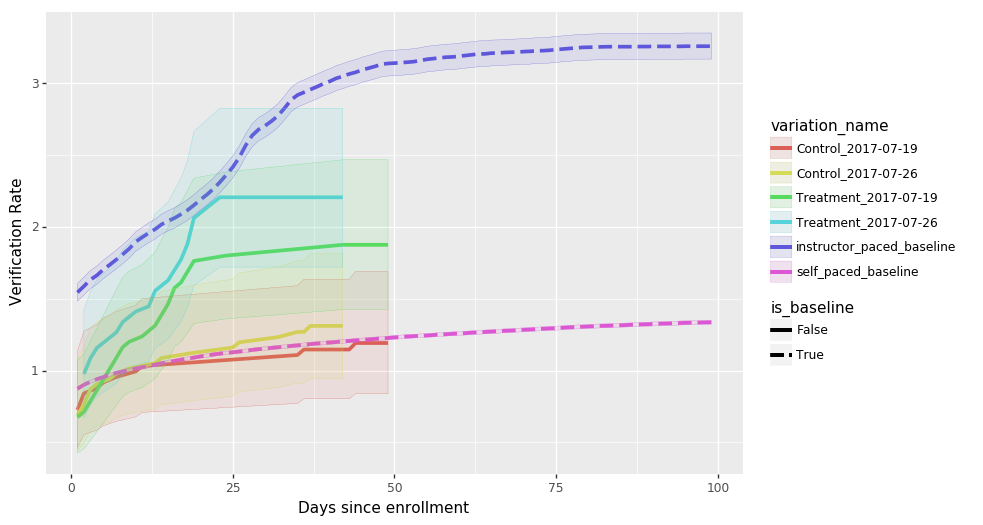

<ggplot: (-9223363300610483761)>

In [33]:
from plotnine import *

df_filter = (all_enrollees.ts < 100) & (all_enrollees.ts > 0)
    

display(
    ggplot(all_enrollees[df_filter].dropna(), aes(
        x='ts',
        y='ps * 100',
        ymin='ps_lo * 100',
        ymax='ps_hi * 100',
        color='variation_name',
        fill='variation_name',
    ))
    + geom_line(aes(linetype='is_baseline'), size=1.5)
    + geom_ribbon(alpha=0.1, size=0.1)
    + xlab('Days since enrollment')
    + ylab('Verification Rate')
    + theme(figure_size=(9, 6))
)

# Compare against *all* instructor paced, not just first-week enrollments

In [34]:
%%vertica (experiment_start, experiment_id) -> audit_duration_counts

SELECT
    exp.variation_name IS NULL AS is_baseline,
    CASE
        WHEN exp.variation_name IS NOT NULL THEN exp.variation_name || '_' || exp.cohort_availability_date
        ELSE c.pacing_type || '_baseline'
    END AS variation_name,
    CASE
        WHEN duc.first_verified_enrollment_time IS NULL THEN DATEDIFF('day', duc.content_availability_date, NOW())
        ELSE DATEDIFF('day', duc.content_availability_date, duc.first_verified_enrollment_time)
    END AS duration,
    duc.first_verified_enrollment_time IS NOT NULL AS verified,
    COUNT(*) AS cnt_users
FROM
    business_intelligence.user_content_availability_date duc
LEFT JOIN
(
    SELECT
        user_id,
        SUBSTRING(key FROM 26) AS course_id,
        CASE MAPLOOKUP(MAPJSONEXTRACTOR(value), 'segment')
            WHEN 0 THEN 'Control'
            WHEN 1 THEN 'Treatment'
        END AS variation_name,
        MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date
    FROM
        lms_read_replica.experiments_experimentdata
    WHERE
        experiment_id = :experiment_id
) exp ON exp.user_id = duc.user_id AND exp.course_id = duc.course_id
JOIN business_intelligence.course_master AS c ON c.course_id = duc.course_id
JOIN production.d_user AS du ON du.user_id = duc.user_id
WHERE
    -- only include enrollments that occurred after the course started and before the verification deadline
    duc.first_enrollment_time <= c.course_verification_end_date
    
    AND du.user_email NOT LIKE '%@edx.org'
    
    AND (
        -- segmentation ensures that you only have a row in the experimentdata table iff you are in the
        -- experiment
        exp.course_id IS NOT NULL
        OR
        -- for all others, just use recent enrollments
        duc.content_availability_date > '2017-04-01'
    )
    
    AND c.course_partner != 'Microsoft'

GROUP BY 1, 2, 3, 4
ORDER BY 1, 4, 2, 3

In [35]:
import pandas as pd
from lifelines import KaplanMeierFitter

plot_num = 0
all_enrollees = pd.DataFrame(columns=['ts', 'ps', 'ps_hi', 'ps_lo', 'is_baseline', 'variation_name'])
        
kmf = KaplanMeierFitter()

for key, group in audit_duration_counts.groupby(
    ['is_baseline', 'variation_name']
):
    is_baseline, variation_name = key

    exploded_group = explode_dataframe(group)
    kmf.fit(exploded_group.duration, event_observed=exploded_group.verified)
    del exploded_group

    ts = kmf.survival_function_.index.values
    ps = 1.0 - kmf.survival_function_['KM_estimate'].values
    ps_hi = 1.0 - kmf.confidence_interval_['KM_estimate_lower_0.95'].values
    ps_lo = 1.0 - kmf.confidence_interval_['KM_estimate_upper_0.95'].values

    all_enrollees = all_enrollees.append(pd.DataFrame({
        'ts': ts,
        'ps': ps,
        'ps_hi': ps_hi,
        'ps_lo': ps_lo,
        'is_baseline': is_baseline,
        'variation_name': variation_name,
    }, columns=all_enrollees.columns))

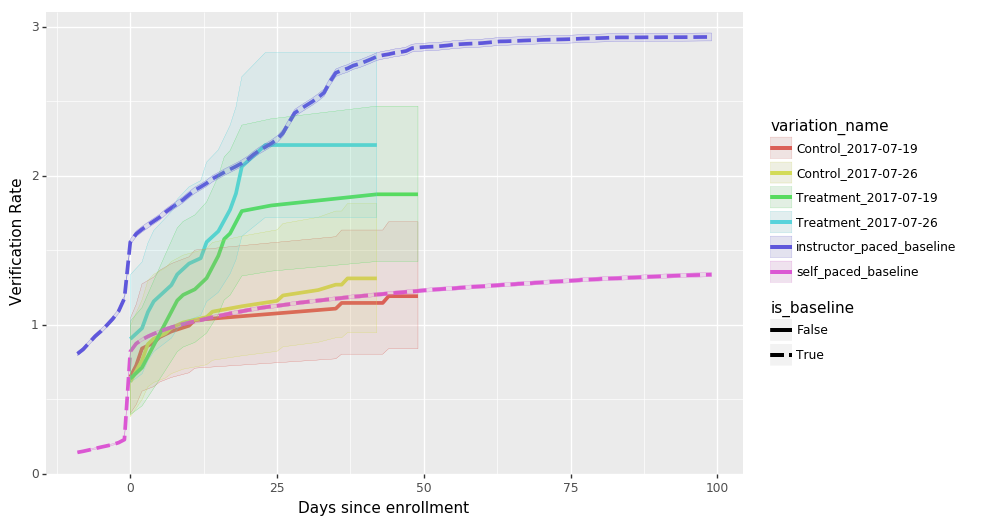

<ggplot: (8736247839254)>

In [36]:
from plotnine import *

df_filter = (all_enrollees.ts < 100) & (all_enrollees.ts > -10)
    

display(
    ggplot(all_enrollees[df_filter].dropna(), aes(
        x='ts',
        y='ps * 100',
        ymin='ps_lo * 100',
        ymax='ps_hi * 100',
        color='variation_name',
        fill='variation_name',
    ))
    + geom_line(aes(linetype='is_baseline'), size=1.5)
    + geom_ribbon(alpha=0.1, size=0.1)
    + xlab('Days since enrollment')
    + ylab('Verification Rate')
    + theme(figure_size=(9, 6))
)